## [1. Import Needed Modules](#import) ##
## [2. Read in images and create a dataframe of image paths and class labels](#makedf) ##
## [3. Balance the train_df dataframe using trim function](#trim) ##
## [4. Create train, test and validation generators](#generators) ##
## [5. Create a function to show Training Image Samples](#show) ##
## [6. Create the Model](#model) ##
## [7. Create a custom Keras callback to continue or halt training](#callback) ##
## [8. Instantiate custom callback and create callbacks to control learning rate and early stopping](#callbacks) ##
## [9. Train the model](#train) ##
## [10. Define a function to plot the training data](#plot) ##
## [11. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [12 Save the model](#save) ##
## [13 Analysis of Model Results](#results) ##




<a id="import"></a>
# <center>Import Need Modules</center>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyunpack
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 1.2 MB/s eta 0:00:00


In [3]:
#from pyunpack import Archive
#Archive('/content/drive/MyDrive/Chicken_Disease_Dataset2.rar').extractall('/content/drive/MyDrive')

In [4]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline
import os, requests, cv2, random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from sklearn.metrics import confusion_matrix,classification_report



<a id="makedf"></a>
# <center>Read in images and create a dataframe of image paths and class labels</center>


In [5]:
train_dir=r'/content/drive/MyDrive/Chicken_Disease_Dataset3/train'
valid_dir=r'/content/drive/MyDrive/Chicken_Disease_Dataset3/val'
for d in [train_dir, valid_dir]:
    filepaths = []
    labels=[]
    classlist=sorted(os.listdir(d))
    for klass in classlist:
        label=klass.split('__')[0]
        classpath=os.path.join(d, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    if d == train_dir:
        df=pd.concat([Fseries, Lseries], axis=1)
    else:
        test_df=pd.concat([Fseries, Lseries], axis=1)
train_df, valid_df=train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  10329   test_df length:  1726   valid_df length:  2583
The number of classes in the dataset is:  4
            CLASS               IMAGE COUNT 
         Coccidiosis               2664     
           Healthy                 2584     
      New Castle Disease           2277     
          Salmonella               2804     
Salmonella  has the most images=  2804   New Castle Disease  has the least images=  2277
average height=  224  average width=  224 aspect ratio=  1.0


<a id="trim"></a>
# <center>Trim the dataset to balance he class samples</center>
### The trim function defined below takes in a dataframe and integers max_samples and min_samples plus
### a column name. It returns a dataframe where each class have no more than max_samples images in
### any class. If a class has less than min_samples images the class is excluded from the dataframe.

In [6]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=2000 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=2000
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  2000  and the minimum samples in any class is  2000


<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [7]:
working_dir=r'./'
img_size=(224,224)
batch_size=64 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 8000 validated image filenames belonging to 4 classes.
Found 2583 validated image filenames belonging to 4 classes.
Found 1726 validated image filenames belonging to 4 classes.
test batch size:  2   test steps:  863  number of classes :  4


<a id="show"></a>
# <center>Create a function to show example training images</center>

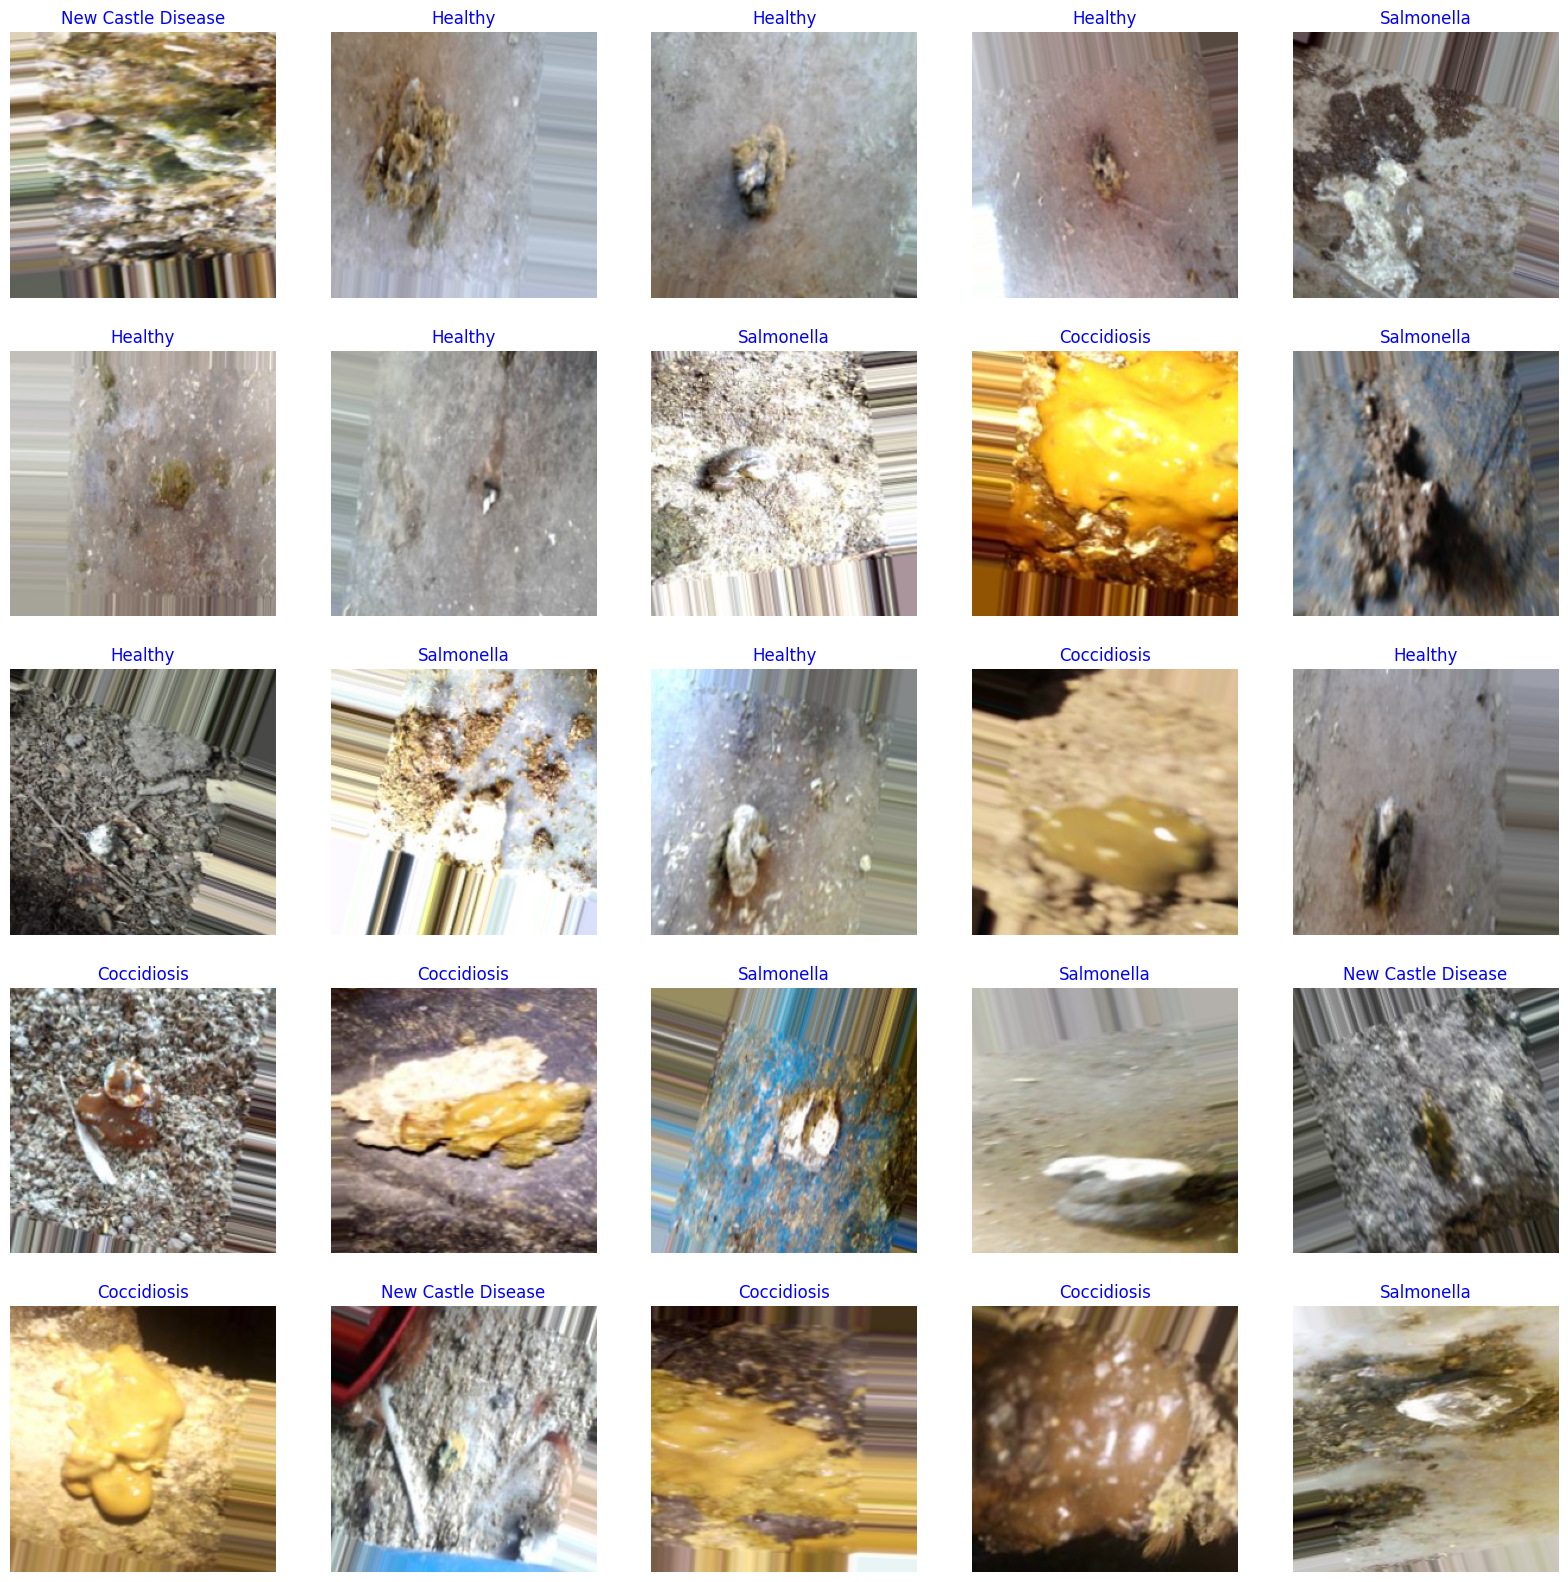

In [8]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB3</center>
### NOTE experts advise you make the base model initially not trainable. Then train for some number of epochs
### then fine tune model by making base model trainable and run more epochs
### I have found this to be WRONG!!!!
### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
### for the same number of total epochs!

In [9]:
# CNN model layers

model=Sequential()

model.add(layers.Conv2D (32, kernel_size = (3,3), activation='relu', input_shape = [224, 224,3])),
model.add(layers.MaxPooling2D(pool_size = (2, 2))),

model.add(layers.Conv2D(64, (3,3), activation='relu')),
model.add(layers. MaxPooling2D((2, 2))),

model.add(layers.Conv2D (64, (3,3), activation='relu')),
model.add(layers.MaxPooling2D((2, 2))),

model.add(layers.Conv2D(64, (3, 3), activation='relu')),
model.add(layers.MaxPooling2D((2, 2))),

model.add(layers. Conv2D (64, (3, 3), activation='relu')),
model.add(layers.MaxPooling2D((2, 2))),

model.add(layers.Conv2D(64, (3, 3), activation='relu')),
model.add(layers.MaxPooling2D((2, 2))),

model.add(layers.Flatten()),

model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(rate=0.5, seed=123))
#output layer
model.add(layers.Dense(4,activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

In [11]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [12]:
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

<a id="callback"></a>
# <center>Create a custom Keras callback to continue or halt training</center>

In [13]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch

    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to')
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time= time.time() # set the time at which training started

    def on_train_end(self, logs=None):   # runs at the end of training
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()

                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

<a id="callbacks"></a>
# <center>Instantiate custom callback and create 2 callbacks to control learning rate and early stop

In [14]:
epochs=70
ask_epoch=50
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset
### It will converge faster and have a lower validation losss

In [15]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 50  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/70
125/125 [==============================] - 1822s 15s/step - loss: 1.3601 - accuracy: 0.4605 - val_loss: 0.8864 - val_accuracy: 0.6225 - lr: 0.0010
Epoch 2/70
125/125 [==============================] - 149s 1s/step - loss: 0.9196 - accuracy: 0.6202 - val_loss: 0.6763 - val_accuracy: 0.7410 - lr: 0.0010
Epoch 3/70
125/125 [==============================] - 137s 1s/step - loss: 0.8227 - accuracy: 0.6906 - val_loss: 0.7075 - val_accuracy: 0.7395 - lr: 0.0010
Epoch 4/70
125/125 [==============================] - ETA: 0s - loss: 0.7036 - accuracy: 0.7502
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
125/125 [==============================] - 139s 1s/step - loss: 0.7036 - accuracy: 0.7502 - val_loss: 0.7869 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 5/70
125/125 [==============================]

<a id="plot"></a>
# <center>Define a function to plot the training data

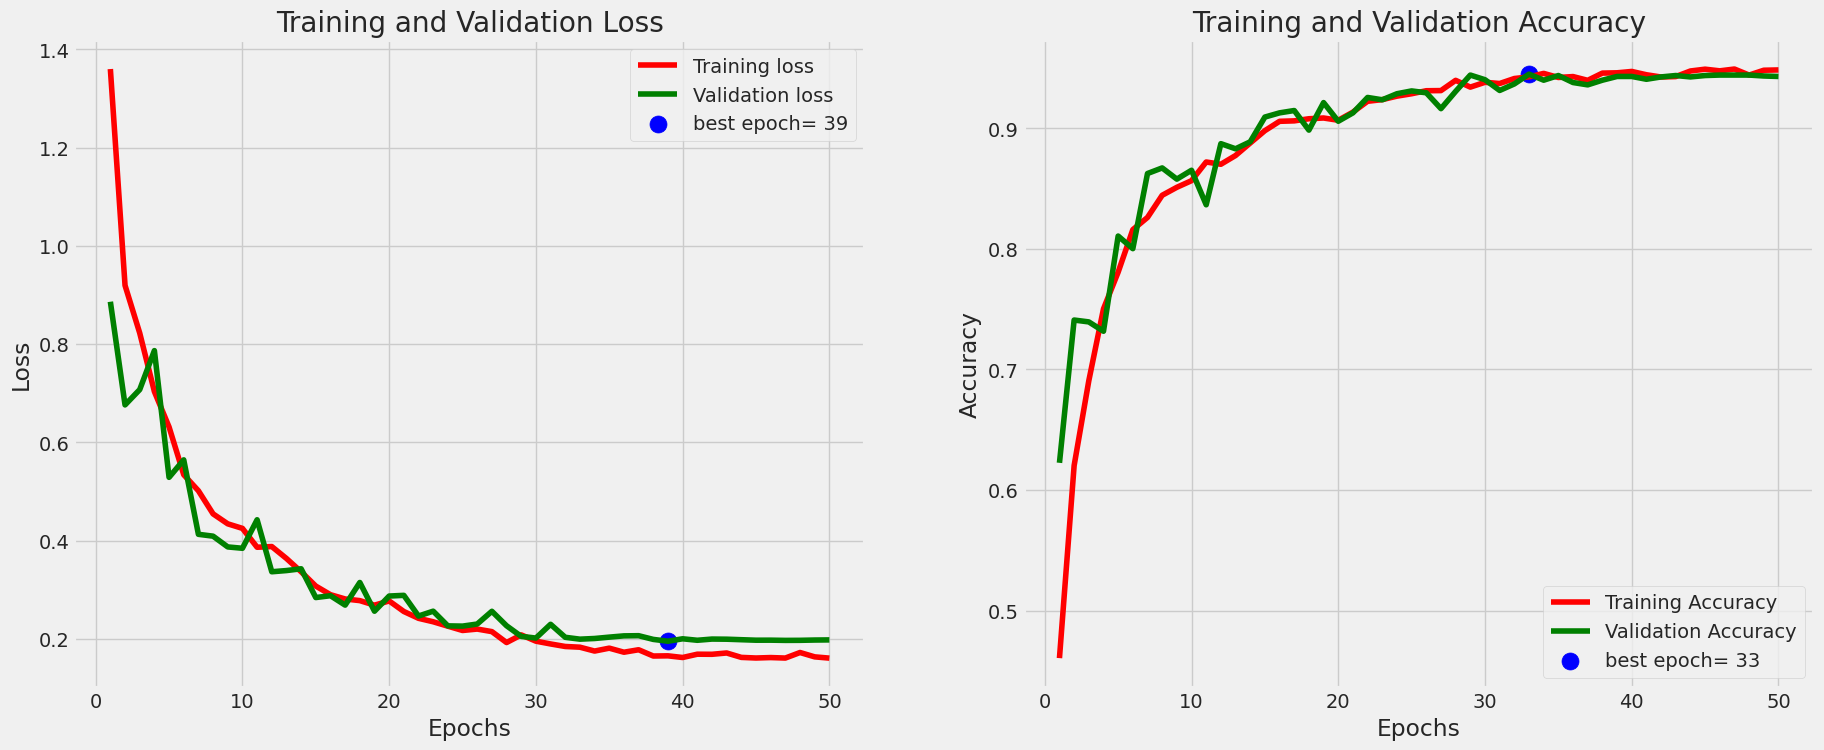

In [16]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(history,0)

In [18]:
model.evaluate(valid_gen)

41/41 [==============================] - 12s 294ms/step - loss: 0.1980 - accuracy: 0.9431


[0.1980064958333969, 0.9430894255638123]

In [22]:
model.evaluate(train_gen)

125/125 [==============================] - 132s 1s/step - loss: 0.1440 - accuracy: 0.9510


[0.14397701621055603, 0.9509999752044678]

<a id="result"></a>
# <center>Make Predictions on the test set</a>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

863/863 [==============================] - 15s 17ms/step
there were 130 in 1726 tests for an accuracy of  92.47


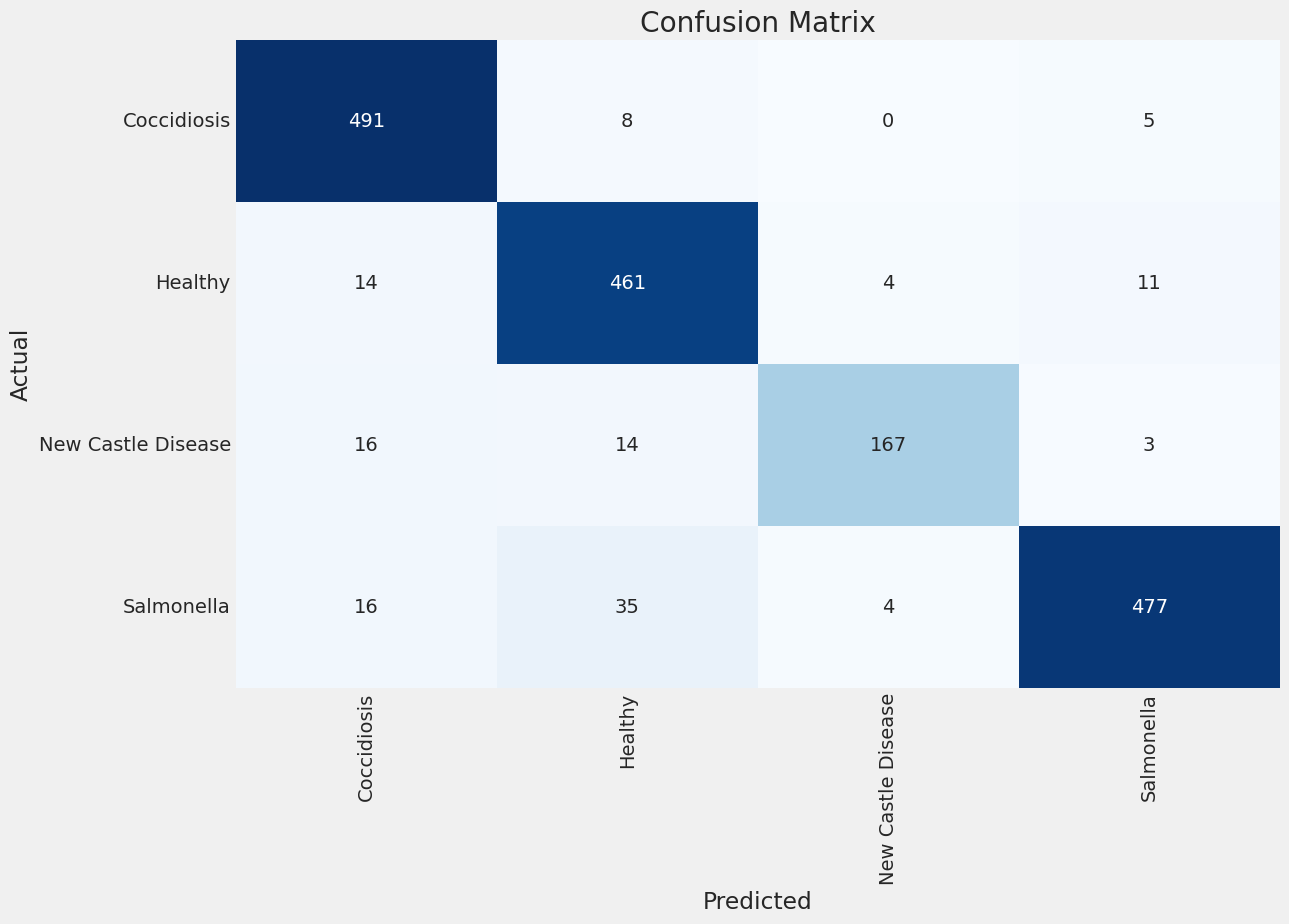

Classification Report:
----------------------
                     precision    recall  f1-score   support

       Coccidiosis     0.9143    0.9742    0.9433       504
           Healthy     0.8900    0.9408    0.9147       490
New Castle Disease     0.9543    0.8350    0.8907       200
        Salmonella     0.9617    0.8966    0.9280       532

          accuracy                         0.9247      1726
         macro avg     0.9301    0.9117    0.9192      1726
      weighted avg     0.9266    0.9247    0.9244      1726



In [21]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)
            true_index=test_gen.labels[i]  # labels are integer values
            if pred_index != true_index: # a misclassification has occurred
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

<a id="results"></a>
# <center>Analysis of Model Performance
In order to reduce training time the number of samples per class was limited to 150 images. We could have
used the trim function with max_samples=198 to get better training accuracy. The image size of the original images
was 600 X 600 but the model was trained with 200 X 200 images again to reduce training time. Overall the model
did well with an average F1 score of 94.5 %. We ran for 12 epochs and the validation loss was still decreasing with
about a 8% reduction in epoch 12. So we could run more epochs and probably acieve a better F1 score.